In [15]:
%pip install -q ../introdl

    torch (>=1.9.*)
           ~~~~~~^
Note: you may need to restart the kernel to use updated packages.


In [1]:
# configuration
data_dir = '../../data' # directory to save data - change as needed

In [2]:
# imports

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

sns.set_theme(style='whitegrid')

plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torchinfo import summary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

from introdl.utils import get_device, load_results, load_model
from introdl.idlmam import train_network
from introdl.visul import show_image_grid, plot_training_metrics



# MNIST Handwritten Digit Classification

## MNIST Handwritten Digits

* 70,000 handwritten digits (0-9). 
* Modified National Institute of Standards and Technology dataset.
* Compiled by **Yann LeCun**, Corinna Cortes, and Christopher J.C. Burges.
* First application of Convolutional Neural Networks.  [Original 1998 paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf)

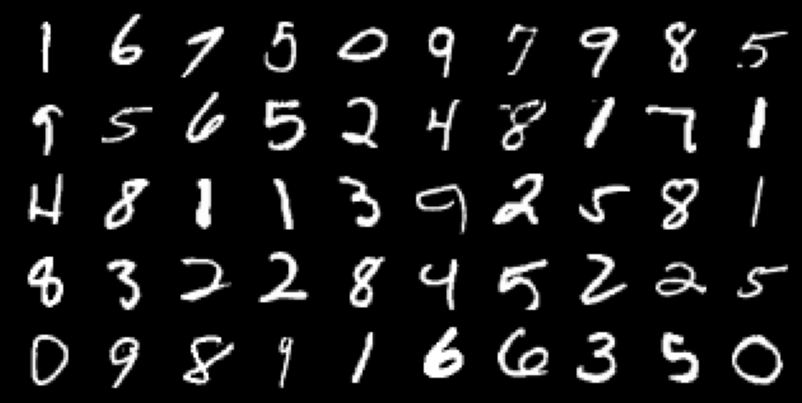

In [3]:
# Define the transform to convert images to tensor and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the MNIST dataset
mnist_dataset = MNIST(root=data_dir, train=True, download=True, transform=transform)

# Example: Display a grid of MNIST digits

show_image_grid(5,10,mnist_dataset,cmap='gray', dark_mode=True, fig_scale=.8)


The background in grayscale images is usually represented by zeros which are often interpreted as black in grayscale colormaps.  If you would prefer to have the digits look like they are drawn on paper you can choose a reversed colormap:

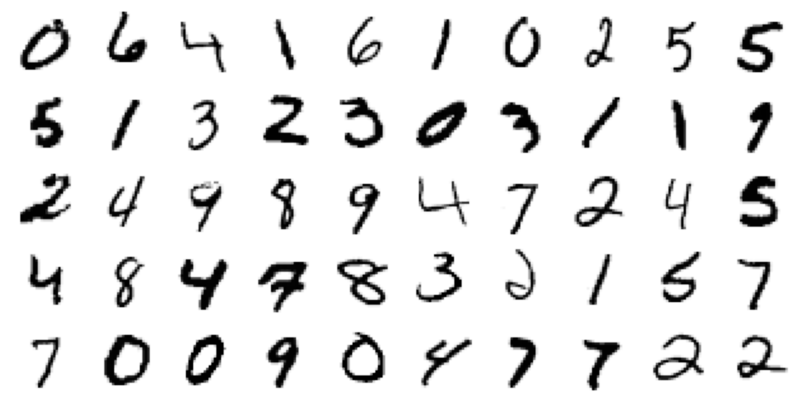

In [4]:
show_image_grid(5,10,mnist_dataset,cmap='Greys',dark_mode=False,fig_scale=.8)

## Image Data

In [5]:
# Load the MNIST dataset
mnist_dataset = MNIST(root=data_dir, train=True, download=True)

# Get an image (you can choose any image)
image, label = mnist_dataset[7]

# Convert the PIL image to a NumPy array
image_np = np.array(image)

# Select a portion of the image (e.g., rows 10 to 40 and columns 10 to 40)
df = pd.DataFrame(image_np[4:26,4:24])

# Apply styling to the DataFrame
styled_df = df.style.set_properties(**{
    'font-size': '8pt', 
    'border-collapse': 'collapse',
    'border': '1px solid black',
    'height': '22px',
    'width': '22px'
}).background_gradient(cmap='gray').set_table_styles([
    {'selector': 'td', 'props': [('border', '1px solid black')]}
]).hide(axis='index').hide(axis='columns')

# Display the styled DataFrame
from IPython.display import display
display(styled_df)


0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,38,43,105,255,253,253,253,253,253,174,6,0,0
0,0,0,0,0,43,139,224,226,252,253,252,252,252,252,252,252,158,14,0
0,0,0,0,0,178,252,252,252,252,253,252,252,252,252,252,252,252,59,0
0,0,0,0,0,109,252,252,230,132,133,132,132,189,252,252,252,252,59,0
0,0,0,0,0,4,29,29,24,0,0,0,0,14,226,252,252,172,7,0
0,0,0,0,0,0,0,0,0,0,0,0,0,85,243,252,252,144,0,0
0,0,0,0,0,0,0,0,0,0,0,0,88,189,252,252,252,14,0,0
0,0,0,0,0,0,0,0,0,0,91,212,247,252,252,252,204,9,0,0
0,0,0,0,0,32,125,193,193,193,253,252,252,252,238,102,28,0,0,0
0,0,0,0,45,222,252,252,252,252,253,252,252,252,177,0,0,0,0,0


## The PyTorch MNIST Dataset

In the previous slide we loaded the MNIST dataset with this code:

```python
mnist_dataset = MNIST(root=data_dir, train=True, download=True)
```

The dataset object is an iterable that takes an index and returns an image and a label:

In [6]:
image, label = mnist_dataset[7]
type(image), type(label)

(PIL.Image.Image, int)

In [7]:
image


## Normalizing Pixel Values

- **Normalization** scales the pixel values to a desired range.

### Why Normalize?
- **Improves model performance** by speeding up convergence.
- Helps the model **handle features at different scales**.

### Common Methods:

1. **Scaling to [0, 1]**:
   - Using `transforms.ToTensor()` in PyTorch:
     ```python
     transforms.ToTensor()  # Scales pixel values from [0, 255] to [0, 1]
     ```

2. **Normalizing to mean 0 and std 1**:
   - This further centers the data with mean **0** and standard deviation **1**:
     ```python
     transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
     ```

## Setup the data

In [8]:
# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean and std of MNIST dataset
])

# Download and load the training dataset
train_dataset = MNIST(root=data_dir, train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Download and load the test dataset
test_dataset = MNIST(root=data_dir, train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)


In [9]:
x,y=next(iter(train_loader))
x.shape

torch.Size([64, 1, 28, 28])

## Define the model

In [10]:
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),             # Flatten the input image to a vector
            nn.Linear(28 * 28, 128),  # Input layer (28x28 pixels) -> hidden layer
            nn.ReLU(),                # Apply ReLU activation function
            nn.Linear(128, 64),       # Hidden layer -> another hidden layer
            nn.ReLU(),                # Apply ReLU activation function
            nn.Linear(64, 10)         # Hidden layer -> output layer (10 classes)
            #nn.Softmax(dim=1)        # Convert logits to "probabilities" - in CE Loss function
            )
    
    def forward(self, x):
        return self.net(x)

# Initialize the model
model = FullyConnectedNN()

## Model Summary

In [11]:
from torchinfo import summary #may need to install torchinfo first

batch_size = 40
summary(model, input_size = (64,1,28,28), col_width=16,
        col_names = ["input_size","output_size","num_params"])

Layer (type:depth-idx)                   Input Shape      Output Shape     Param #
FullyConnectedNN                         [64, 1, 28, 28]  [64, 10]         --
├─Sequential: 1-1                        [64, 1, 28, 28]  [64, 10]         --
│    └─Flatten: 2-1                      [64, 1, 28, 28]  [64, 784]        --
│    └─Linear: 2-2                       [64, 784]        [64, 128]        100,480
│    └─ReLU: 2-3                         [64, 128]        [64, 128]        --
│    └─Linear: 2-4                       [64, 128]        [64, 64]         8,256
│    └─ReLU: 2-5                         [64, 64]         [64, 64]         --
│    └─Linear: 2-6                       [64, 64]         [64, 10]         650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 7.00
Input size (MB): 0.20
Forward/backward pass size (MB): 0.10
Params size (MB): 0.44
Estimated Total Size (MB): 0.74

## Define the model - version 2

In [12]:
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input layer (28x28 pixels) -> hidden layer
        self.fc2 = nn.Linear(128, 64)       # Hidden layer -> another hidden layer
        self.fc3 = nn.Linear(64, 10)        # Hidden layer -> output layer (10 classes)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input image to a vector
        x = F.relu(self.fc1(x))   # Apply ReLU activation function
        x = F.relu(self.fc2(x))   # Apply ReLU activation function
        x = self.fc3(x)           # Output layer (logits)
        return x

# Initialize the model
model = FullyConnectedNN()

## Setup training

We're going to cheat a bit here and use a variant of gradient descent called the AdamW optimizer.  We'll talk more about optimizers in lesson 3, but it would be a shame to wait until then to use it because it's much more efficient than vanilla gradient descent.

In [13]:
loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(model.parameters())  # AdamW optimizer, default lr=0.001

device = get_device()
print(device)

ckpt_file = 'models/model_MNIST_FC.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}

mps


## Train

In [14]:
results_MNIST_FC = train_network(model,
                                 loss_func,
                                 train_loader,
                                 device=device,
                                 test_loader=test_loader,
                                 epochs = epochs,
                                 optimizer = optimizer,
                                 score_funcs = score_funcs,
                                 checkpoint_file=ckpt_file)

Epoch: 100%|██████████| 10/10 [01:25<00:00,  8.59s/it]


## Results

We get 97% to 98% accuracy on the validation set after only a few epochs!

In [15]:
ckpt_file = 'models/model_MNIST_FC.pt'
results_MNIST_FC = load_results(ckpt_file)

results_MNIST_FC

,epoch,total time,train loss,test loss,train ACC,test ACC
0,0,8.359478,0.276868,0.170522,0.918333,0.9472
1,1,16.338320,0.118378,0.096091,0.963433,0.9691
2,2,24.315233,0.082073,0.094202,0.974750,0.9704
3,3,32.245601,0.062380,0.094343,0.980050,0.9717
4,4,40.198638,0.050300,0.080927,0.984150,0.9744
5,5,48.097176,0.042819,0.093234,0.985933,0.9731
6,6,55.992711,0.034116,0.082541,0.989033,0.9758
7,7,63.821583,0.031176,0.072453,0.989717,0.9786
8,8,71.723969,0.026072,0.090668,0.991100,0.9772
9,9,79.631191,0.025419,0.086589,0.991150,0.9767


You can also view the results graphically if you would prefer.

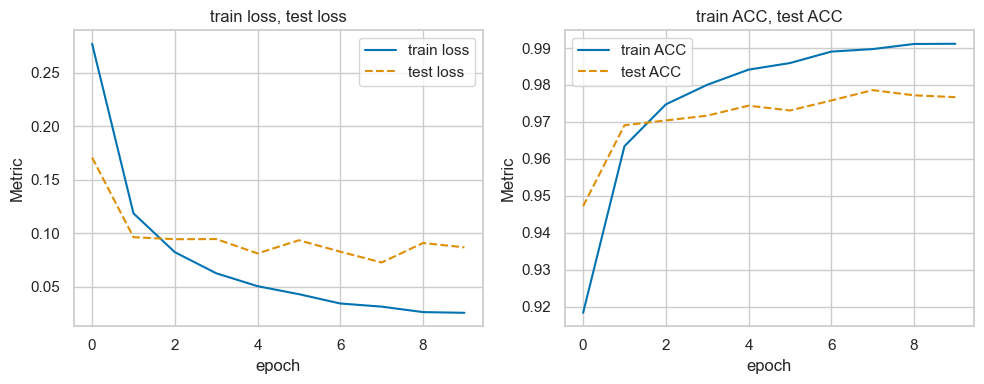

In [16]:
plot_training_metrics(results_MNIST_FC, [['train loss', 'test loss'], ['train ACC', 'test ACC']])

After epoch 2 (the third epoch, silly Python indexing ...) there is some evidence of mild overfitting since the training loss continues to decrease while the test loss remains constant.  This indicates that the network is memorizing details of the training set instead of learning to generalize.  Though it's pretty amazing that we have greater than 97% accuracy on the test set without much effort!

We could simply stop the training after the third epoch.  We'll see more about dealing with overfitting in the next lesson.

### Evaluating the Model

Greater than 97% accuracy is pretty amazing for our first effort.  Whenever you're working on a model it's important to understand the instances that the model predicts incorrectly.  Sometimes this gives insight into how the model can be improved.

The code below shows how to loop over the test dataset and collect all the labels, predictions, and misclassified images. It also displays the confusion matrix.  Inspect the confusion matrix to look for common errors.  For example nines are frequently misclassified as fours.

Total number of images: 10000
Number of misclassified images: 233


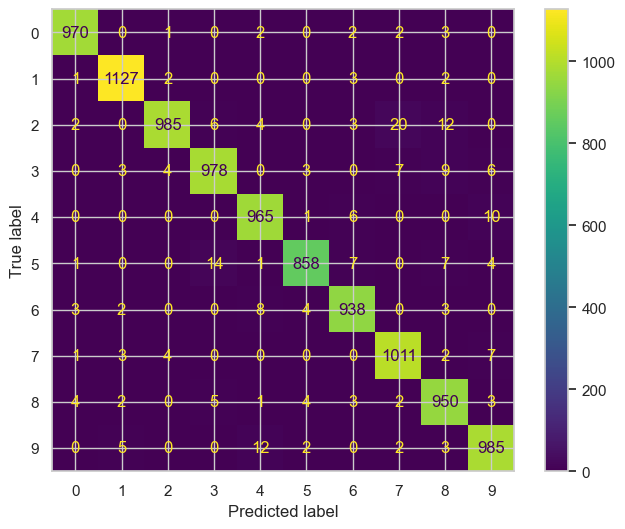

In [17]:
device = get_device()
model = load_model(FullyConnectedNN, 'models/model_MNIST_FC.pt', device)

# Set the model to evaluation mode
model.eval()

# Collect the labels, predicted labels, and misclassified images
labels = []
pred_labels = []
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

# Iterate over the test dataset
for images, targets in test_loader:
    # Move the images and targets to the device
    images = images.to(device)
    targets = targets.to(device)
    
    # Forward pass
    outputs = model(images)
    
    # Get the predicted labels
    _, predicted = torch.max(outputs.data, 1)
    
    # Append the labels and predicted labels to the lists
    labels.extend(targets.cpu().numpy())
    pred_labels.extend(predicted.cpu().numpy())
    
    # Collect misclassified images
    for i in range(len(targets)):
        if targets[i] != predicted[i]:
            misclassified_images.append(images[i].cpu().numpy())
            misclassified_true_labels.append(targets[i].item())
            misclassified_pred_labels.append(predicted[i].item())

# Print the total number of images and the number of misclassified images
total_images = len(labels)
num_misclassified = len(misclassified_images)
print(f'Total number of images: {total_images}')
print(f'Number of misclassified images: {num_misclassified}')

# Compute the confusion matrix
confusion_mat = confusion_matrix(labels, pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_mat)
disp.plot()
plt.show()

It's a good idea to look at the images that are misclassified.  Running the cell below will display 25 misclassified digits selected at random.  Are you surprised by any of the misclassifications? Run the cell repeatedly to see different samples of misclassified digits.

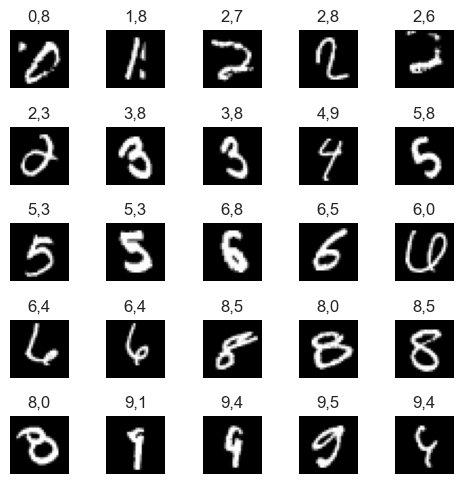

In [18]:
# Plot a random sample of 25 misclassified images (or fewer if there aren't 25), ordered by true label
num_images_to_plot = min(25, num_misclassified)
random_indices = np.random.choice(num_misclassified, num_images_to_plot, replace=False)

# Sort the selected misclassified images by their true labels
sorted_indices = sorted(random_indices, key=lambda i: misclassified_true_labels[i])

num_cols = 5
num_rows = (num_images_to_plot + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, num_rows))
axes = axes.flatten()

for i in range(num_rows * num_cols):
    if i < num_images_to_plot:
        idx = sorted_indices[i]
        image = misclassified_images[idx].squeeze()  # Remove channel dimension if present
        true_label = misclassified_true_labels[idx]
        pred_label = misclassified_pred_labels[idx]
        
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'{true_label},{pred_label}')
        axes[i].axis('off')
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.show()